NESTML spike frequency adaptation tutorial
==========================================

Welcome to the NESTML spike frequency adaptation (SFA) tutorial. Here, we will go step by step through adding two different types of SFA mechanism to a neuron model, threshold adaptation and an adaptation current [1], and then evaluate how the new models behave in simulation.

#### Table of contents

- [Introduction](#introduction)
- [Threshold-based SFA](#threshold-based-adaptation)
- [Current-based SFA](#current-based-adaptation)

<a name="introduction"></a>

Introduction
------------

A neuron that is stimulated by rectangular current injections initially responds with a high firing rate, followed by a decrease in the firing rate. This phenomenon is called *spike-frequency adaptation* and is usually mediated by slow K<sup>+</sup> currents, such as a Ca<sup>2+</sup>-activated K<sup>+</sup> current [3]. This behaviour is typically modelled in one of two ways:

*Threshold adaptation:* The threshold for generating an action potential is increased every time an action potential occurs. The threshold slowly decays back to its original value.

*Potassium membrane current:* An extra transmembrane current is added to the neuron, that is increased step-wise every time an action potential occurs, and slowly decays back to its original value.

**Quiz:** If a typical point neuron model has a characteristic timescale (in its membrane potential dynamics) of 20&nbsp;ms, what would be good order-of-magnitude estimate to give to the adaptation characteristic timescale? How does refractoriness figure into this?

**Hints:** <span style="color:white">Considerably longer than the neuron timescale, e.g. 200 ms; refractoriness defines a maximum neuron firing rate; consider maximum and minimum obtained firing rates in the presence of the SRA mechanism.</span>

We will take a simple current-based integrate-and-fire model with alpha-shaped postsynaptic response kernels (``iaf_psc_alpha``) as the basis for our modifications. First, let's take a look at this base neuron without any modifications.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
from pynestml.frontend.pynestml_frontend import to_nest, install_nest
#import elephant

### Base model: no adaptation

Let's first make sure that we have all the necessary files.

If you are running this notebook locally or cloned the repository, the NESTML model ``iaf_psc_alpha.nestml`` is contained in the subdirectory ``models``. You can open NESTML model files in your favourite code editor (check https://github.com/nest/nestml/ for syntax highlighting support).

In case you are running this notebook in JupyerLab on a remote system, you can edit the model files directly in your browser by running the following cell to dynamically fetch them from the tutorial repository. Don't forget to refresh the list of files on the "File Browser" panel on the left.

In [2]:
import urllib.request
fnames = ["iaf_psc_alpha.nestml",
          "iaf_psc_alpha_adapt_thresh.nestml",
          "iaf_psc_alpha_adapt_thresh_OU.nestml",
          "iaf_psc_alpha_spike_rate_adapt.nestml"]
for fname in fnames:
    url = "https://raw.githubusercontent.com/clinssen/OCNS-2020-workshop/master/materials/nestml/models/" + fname
    contents = urllib.request.urlopen(url).read()
    with open(fname, 'wb') as out:
        out.write(contents)

In [3]:
to_nest(input_path="iaf_psc_alpha.nestml",
        target_path="/tmp/nestml-target",
        module_name="nestml_iaf_psc_alpha_module",
        suffix="_nestml")
install_nest("/tmp/nestml-target", "/home/charl/julich/nest-simulator-build")
nest.Install("nestml_iaf_psc_alpha_module")

Validating input...
Analyzing shapes...
  I_shape_in is a linear homogeneous ODE
  I_shape_ex is a linear homogeneous ODE
Analyzing ODEs...
  V_abs is a linear constant coefficient ODE.
Generating solvers...
  V_abs: analytical


Now, the NESTML model is ready to be used in a simulation.

In [4]:
def evaluate_neuron(neuron_name, neuron_parms=None, stimulus_type="constant",
                    mu=500., sigma=0., t_sim=300., plot=True):
    """
    Run a simulation in NEST for the specified neuron. Inject a stepwise
    current and plot the membrane potential dynamics and spikes generated.
    """
    dt = .1   # [ms]

    nest.ResetKernel()
    neuron = nest.Create(neuron_name)
    if neuron_parms:
        for k, v in neuron_parms.items():
            nest.SetStatus(neuron, k, v)
    
    if stimulus_type == "constant":
        nest.SetStatus(neuron, "I_e", mu)
        assert sigma == 0.
    elif stimulus_type == "Ornstein-Uhlenbeck":
        nest.SetStatus(neuron, "I_noise0", mu)
        nest.SetStatus(neuron, "sigma_noise", sigma)
    else:
        raise Exception("Unknown stimulus type: " + str(stimulus_type))
    
    multimeter = nest.Create("multimeter")
    multimeter.set({"record_from": ["V_m"],
                    "interval": dt})
    spikedetector = nest.Create("spike_detector")
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spikedetector)
    
    nest.Simulate(t_sim)

    dmm = nest.GetStatus(multimeter)[0]
    Voltages = dmm["events"]["V_m"]
    tv = dmm["events"]["times"]
    dSD = nest.GetStatus(spikedetector, keys='events')[0]
    spikes = dSD['senders']
    ts = dSD["times"]
    
    _idx = [np.argmin((tv - spike_time)**2) - 1 for spike_time in ts]
    V_m_at_spike_times = Voltages[_idx]
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(tv, Voltages)
        ax.scatter(ts, V_m_at_spike_times)
        ax.set_xlabel("Time [ms]")
        ax.set_ylabel("V_m [mV]")
        ax.grid()

    return ts

array([ 13.9,  29.8,  45.7,  61.6,  77.5,  93.4, 109.3, 125.2, 141.1,
       157. , 172.9, 188.8, 204.7, 220.6, 236.5, 252.4, 268.3, 284.2])

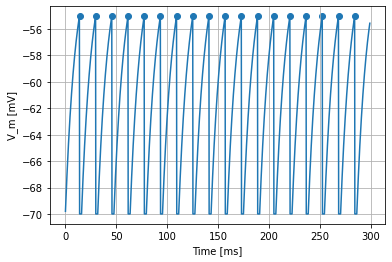

In [5]:
evaluate_neuron("iaf_psc_alpha_nestml")

<a name="threshold-based-adaptation"></a>

Threshold-based adaptation
--------------------------

We reflect spike-frequency adaptation by increasing the firing threshold $\Theta$ by $\Delta\Theta$ the moment the neuron fires. Between firing events, $\Theta$ evolves according to

\begin{align}
\frac{d\Theta}{dt} &= -(\Theta - \Theta_{init}) / \tau_\Theta
\end{align}

such that the firing threshold decays to the constant non-adapted firing threshold, in the absence of firing events, and $\tau_\Theta$ determines the decay rate.



### Adjusting the NESTML model

**Task:** Create a new file and name it, for example, ``iaf_psc_alpha_adapt_thresh.nestml``. Copy the contents of ``iaf_psc_alpha.nestml`` and make the following changes.

First, define the parameters:  

```
parameters:
  [...]
  tau_sra ms = 100 ms
  Delta_I_sra pA = 100 pA
end
```

Add the new state variables and initial values:
```
initial_values:
  [...]
  I_sra pA = 0 pA
end
```

```
equations:
  [...]
  I_sra' = -I_sra / tau_sra
end
```

and add the new term to the dynamical equation for `V_abs`:
```
equations:
  [...]
  function I pA = convolve(I_shape_in, in_spikes) + convolve(I_shape_ex, ex_spikes) - I_sra + I_e + I_stim
  V_abs' = -V_abs / Tau + I / C_m
end
```

Increment the adaptation current whenever the neuron fires:

```
update:
  [...]
  if V_abs >= Theta:
    I_sra += Delta_I_sra
    emit_spike()
  end
end
```



In [6]:
to_nest(input_path="/home/charl/julich/nestml-upstream/nestml/models_for_sra/iaf_psc_alpha_adapt_thresh.nestml",
        target_path="/tmp/nestml-target",
        module_name="nestml_sra_adapt_thresh_module",
        suffix="_nestml",
        logging_level="INFO")
install_nest("/tmp/nestml-target", "/home/charl/julich/nest-simulator-build")
nest.Install("nestml_sra_adapt_thresh_module")

[1,GLOBAL, INFO]: Start processing '/home/charl/julich/nestml-upstream/nestml/models_for_sra/iaf_psc_alpha_adapt_thresh.nestml'!
[2,GLOBAL, INFO]: New type registered 'pA2'!
[3,GLOBAL, INFO]: New type registered 'pA2 / ms'!
[4,iaf_psc_alpha_adapt_thresh_nestml, INFO, [85:0;163:0]]: Start building symbol table!
[5,iaf_psc_alpha_adapt_thresh_nestml, INFO]: New type registered '1 / ms'!
[6,iaf_psc_alpha_adapt_thresh_nestml, WARNING, [108:4;108:20]]: Variable 'Tau' has the same name as a physical unit!
[7,iaf_psc_alpha_adapt_thresh_nestml, INFO]: New type registered 'mV / s'!
[8,iaf_psc_alpha_adapt_thresh_nestml, INFO]: New type registered 'mV / ms'!
[9,iaf_psc_alpha_adapt_thresh_nestml, INFO]: New type registered '1 / pF'!
[10,iaf_psc_alpha_adapt_thresh_nestml, INFO]: New type registered 'pA / pF'!
[11,iaf_psc_alpha_adapt_thresh_nestml, WARNING, [102:13;102:22]]: Non-matching unit types at mV / ms +/- pA / pF! Implicitly replaced by mV / ms +/- 1.0 * pA / pF.
[12,iaf_psc_alpha_adapt_thres

array([ 13.9,  33.9,  58.6,  88.3, 122.2, 158.8, 196.7, 235.2, 273.9])

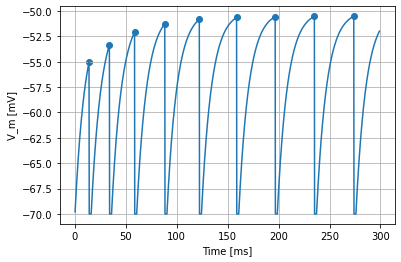

In [7]:
evaluate_neuron("iaf_psc_alpha_adapt_thresh_nestml")


<a name="current-based-adaptation"></a>

Current-based adaptation
------------------------

Specifically incorporate an adaptation current $I_{sra}(t)$ while keeping the firing threshold constant. The current will always be non-negative, and is set up so that the current will hyperpolarise the neuron. The dynamical system model is adjusted in this case to

\begin{align}
\frac{dV_m}{dt} &= (I_{syn} + I_{ext} - I_{sra}) / \tau_m\\
\frac{dI_{sra}}{dt} &= -I_{sra} / \tau_{sra}
\end{align}

where $I_{sra}$ is instantaneously increased by $\Delta{}I_{sra}$ at each the neuron fires and $\tau_{sra}$ controls the decay rate for the adaptation current.

**Task:** As for the threshold adaptation case, create a new model file and make the necessary adjustments.

In [8]:
to_nest(input_path="/home/charl/julich/nestml-upstream/nestml/models_for_sra/iaf_psc_alpha_spike_rate_adapt.nestml",
        target_path="/tmp/nestml-target",
        module_name="nestml_sra_curr_module",
        suffix="_nestml",
        logging_level="INFO")
install_nest("/tmp/nestml-target", "/home/charl/julich/nest-simulator-build")
nest.Install("nestml_sra_curr_module")


[1,GLOBAL, INFO]: Start processing '/home/charl/julich/nestml-upstream/nestml/models_for_sra/iaf_psc_alpha_spike_rate_adapt.nestml'!
[2,iaf_psc_alpha_spike_rate_adapt_nestml, INFO, [85:0;153:0]]: Start building symbol table!
[3,iaf_psc_alpha_spike_rate_adapt_nestml, INFO]: New type registered '1 / ms'!
[4,iaf_psc_alpha_spike_rate_adapt_nestml, WARNING, [107:4;107:20]]: Variable 'Tau' has the same name as a physical unit!
[5,iaf_psc_alpha_spike_rate_adapt_nestml, INFO]: New type registered 'mV / s'!
[6,iaf_psc_alpha_spike_rate_adapt_nestml, INFO]: New type registered 'mV / ms'!
[7,iaf_psc_alpha_spike_rate_adapt_nestml, INFO]: New type registered 'pA / pF'!
[8,iaf_psc_alpha_spike_rate_adapt_nestml, WARNING, [101:13;101:22]]: Non-matching unit types at mV / ms +/- pA / pF! Implicitly replaced by mV / ms +/- 1.0 * pA / pF.
[9,iaf_psc_alpha_spike_rate_adapt_nestml, INFO]: New type registered 'pA / s'!
[10,iaf_psc_alpha_spike_rate_adapt_nestml, INFO]: New type registered 'pA / ms'!
[11,iaf_p

array([ 13.9,  39.4,  89.8, 154.8, 220.6, 286.4])

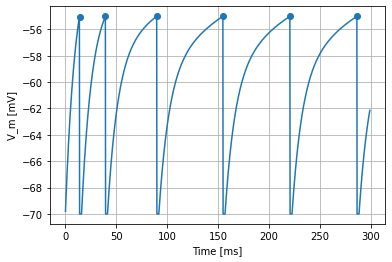

In [9]:
evaluate_neuron("iaf_psc_alpha_spike_rate_adapt_nestml")

### Slope-dependent threshold

As an extra challenge: implement the slope-dependent threshold from https://www.pnas.org/content/97/14/8110

Characterisation
----------------

### f-I curve




In [10]:
def measure_fI_curve(I_stim_vec, neuron_model_name):
    t_stop = 10000.   # simulate for a long time to make any startup transients insignificant [ms]

    rate_testant = float("nan") * np.ones_like(I_stim_vec)
    for i, I_stim in enumerate(I_stim_vec):
        nest.ResetKernel()
        neuron = nest.Create(neuron_model_name)

        dc = nest.Create("dc_generator", params={"amplitude": I_stim * 1E12}) # 1E12: convert A to pA
        nest.Connect(dc, neuron)

        sd_testant = nest.Create('spike_detector')
        nest.Connect(neuron, sd_testant)

        nest.Simulate(t_stop)

        rate_testant[i] = sd_testant.n_events / t_stop * 1000

    return rate_testant

In [11]:
def plot_fI_curve(I_stim_vec, label_to_rate_vec):
    if len(I_stim_vec) < 40:
        marker = "o"
    else:
        marker = None
    fig, ax = plt.subplots()
    ax = [ax]
    for label, rate_vec in label_to_rate_vec.items():
        ax[0].plot(I_stim_vec * 1E12, rate_vec, marker=marker, label=label)
    for _ax in ax:
        _ax.legend(loc='upper right')
        _ax.grid()
        _ax.set_ylabel("Firing rate [Hz]")
    ax[0].set_xlabel("$I_{inj}$ [pA]")
    plt.tight_layout()


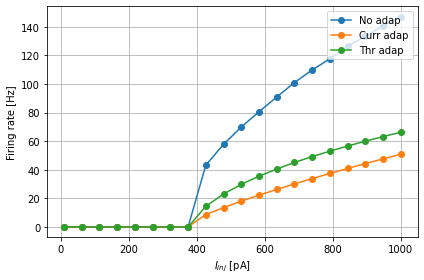

In [12]:
I_stim_vec = np.linspace(10E-12, 1E-9, 20)     # [A]
rate_vec = measure_fI_curve(I_stim_vec, "iaf_psc_alpha_nestml")
rate_vec_adapt = measure_fI_curve(I_stim_vec, "iaf_psc_alpha_spike_rate_adapt_nestml")
rate_vec_thresh_adapt = measure_fI_curve(I_stim_vec, "iaf_psc_alpha_adapt_thresh_nestml")
plot_fI_curve(I_stim_vec, {"No adap": rate_vec,
                           "Curr adap" : rate_vec_adapt,
                           "Thr adap" : rate_vec_thresh_adapt})

**Task:** Can you make the current adaptation model curve and threshold adaptation curve overlap? Can you do this without re-generating the NESTML models?

### CV vs. firing rate

Fig 8C from [3]

The Ornstein-Uhlenbeck process $U_t$ (with $t\geq 0$) is the solution of the following stochastic differential equation:

...

If the process is observed at discrete equally spaced times $t_i=i\cdot h$, where $h$ is the sampling time, the solution can be put into the following iterative form:

\begin{align}
U_i = U_{i-1}\cdot\exp(h/\tau) + N(0, \frac{\sigma^2\tau}{2}(1 - \exp(-2h/\tau))
\end{align}

First, add Ornstein-Uhlenbeck noise process to neuron:

\begin{align}
\frac{d{I}_{\mathrm{noise}}}{dt}=-\frac{I_{\mathrm{noise}}-\mu }{\tau_{\mathrm{syn}}}+\sqrt{\frac{2{\sigma}^2}{\tau_{\mathrm{syn}}}}\eta (t)
\end{align}

where $\eta(t)$ is the Gaussian white noise process with zero mean and unit variance.

```
parameters:
  I_noise0 pA = 500 pA      # mean of the noise current
  sigma_noise pA = 50 pA    # std. dev. of the noise current
end

internals:
  [...]
  D_noise pA**2/ms = 2 * sigma_noise**2 / tau_syn
  A_noise pA = ((D_noise * tau_syn / 2) * (1 - exp(-2 * resolution() / tau_syn )))**.5
end
```

```
state:
  I_noise pA = I_noise0
end
```

```
update:
  [...]
  I_noise = I_noise0
            + (I_noise - I_noise0) * exp(-resolution() / tau_syn)
            + A_noise * random_normal(0, 1)
end
```


In [13]:
to_nest(input_path="/home/charl/julich/nestml-upstream/nestml/models_for_sra/iaf_psc_alpha_adapt_thresh_OU.nestml",
        target_path="/tmp/nestml-target",
        module_name="nestml_adapt_thresh_OU_module",
        suffix="_nestml",
        logging_level="INFO")
install_nest("/tmp/nestml-target", "/home/charl/julich/nest-simulator-build")
nest.Install("nestml_adapt_thresh_OU_module")


[1,GLOBAL, INFO]: Start processing '/home/charl/julich/nestml-upstream/nestml/models_for_sra/iaf_psc_alpha_adapt_thresh_OU.nestml'!
[2,GLOBAL, INFO]: New type registered 'pA2'!
[3,GLOBAL, INFO]: New type registered 'pA2 / ms'!
[4,iaf_psc_alpha_adapt_thresh_OU_nestml, INFO, [85:0;163:0]]: Start building symbol table!
[5,iaf_psc_alpha_adapt_thresh_OU_nestml, INFO]: New type registered '1 / ms'!
[6,iaf_psc_alpha_adapt_thresh_OU_nestml, WARNING, [108:4;108:20]]: Variable 'Tau' has the same name as a physical unit!
[7,iaf_psc_alpha_adapt_thresh_OU_nestml, INFO]: New type registered 'mV / s'!
[8,iaf_psc_alpha_adapt_thresh_OU_nestml, INFO]: New type registered 'mV / ms'!
[9,iaf_psc_alpha_adapt_thresh_OU_nestml, INFO]: New type registered '1 / pF'!
[10,iaf_psc_alpha_adapt_thresh_OU_nestml, INFO]: New type registered 'pA / pF'!
[11,iaf_psc_alpha_adapt_thresh_OU_nestml, WARNING, [102:13;102:22]]: Non-matching unit types at mV / ms +/- pA / pF! Implicitly replaced by mV / ms +/- 1.0 * pA / pF.
[1

Let's first do some sanity check that our model is behaving as expected. If we set $\sigma$ to zero, the response should match the one for the constant current input, so the following two plots should look exactly the same:

array([ 16.1,  36.1,  60.8,  90.5, 124.4, 161. , 198.9, 237.4, 276.1])

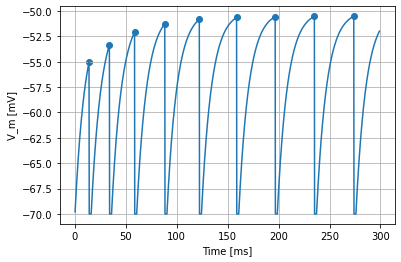

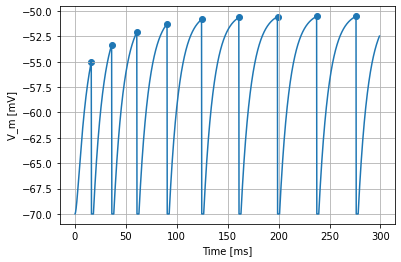

In [14]:
evaluate_neuron("iaf_psc_alpha_adapt_thresh_OU_nestml", stimulus_type="constant", mu=500.)
evaluate_neuron("iaf_psc_alpha_adapt_thresh_OU_nestml", stimulus_type="Ornstein-Uhlenbeck", mu=500., sigma=0.)


Now, for the same $\mu$=500 pA, but setting $\sigma$=200 pA/√ms, the effect of the noise can be clearly seen in the membrane potential trace and in the spiking irregularity: 

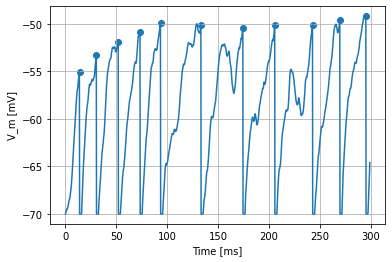

In [16]:
spike_times = evaluate_neuron("iaf_psc_alpha_adapt_thresh_OU_nestml",
                              stimulus_type="Ornstein-Uhlenbeck",
                              mu=500.,
                              sigma=200.)

Let's first do a sanity check and plot a distribution of the interspike intervals, as well as their mean and standard deviation interval.

Mean: 35.51174377224199
Std. dev.: 16.383833630520275


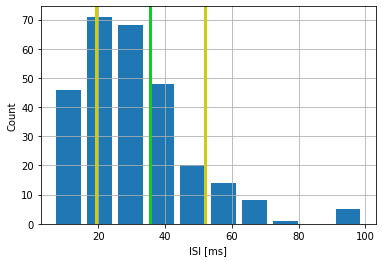

In [17]:
spike_times = evaluate_neuron("iaf_psc_alpha_adapt_thresh_OU_nestml",
                              stimulus_type="Ornstein-Uhlenbeck",
                              mu=500.,
                              sigma=200.,
                              t_sim=10000.,
                              plot=False)

ISI = np.diff(spike_times)
ISI_mean = np.mean(ISI)
ISI_std = np.std(ISI)

print("Mean: " + str(ISI_mean))
print("Std. dev.: " + str(ISI_std))

count, bin_edges = np.histogram(ISI)

fig, ax = plt.subplots()
ax.bar(bin_edges[:-1], count, width=.8 * (bin_edges[1] - bin_edges[0]))
ylim = ax.get_ylim()
ax.plot([ISI_mean, ISI_mean], ax.get_ylim(), c="#11CC22", linewidth=3)
ax.plot([ISI_mean - ISI_std, ISI_mean - ISI_std], ylim, c="#CCCC11", linewidth=3)
ax.plot([ISI_mean + ISI_std, ISI_mean + ISI_std], ylim, c="#CCCC11", linewidth=3)
ax.set_ylim(ylim)
ax.set_xlabel("ISI [ms]")
ax.set_ylabel("Count")
ax.grid()


**Task:** The CV is defined as the standard deviation of the ISIs divided by the mean:

\begin{align}
CV = \frac{\sigma}{\mu}
\end{align}

Comment on whether the coefficient of variation is an appropriate metric to use.

Now, we can use the ISIs to calculate the coefficient of variation. Sanity check: Poisson process should have CV = 1 irrespective of the rate.

In [18]:
mean_interval = 1.
isi = np.random.exponential(mean_interval, 1000)
print("For a Poisson process:")
print("CV = " + str(np.std(isi) / np.mean(isi)))

For a Poisson process:
CV = 1.0025890118681824


In [19]:
CV = np.std(ISI) / np.mean(ISI)
print("CV: " + str(np.std(ISI) / np.mean(ISI)))


CV: 0.4613638163081931


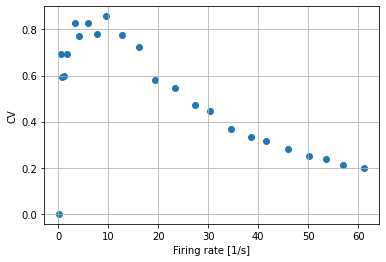

In [26]:
N = 40
t_sim = 10E3  # [ms]
CV = np.nan * np.ones(N)
rate = np.nan * np.ones(N)
for i, mu in enumerate(np.logspace(np.log10(150.), np.log10(500.), N)):
    spike_times = evaluate_neuron("iaf_psc_alpha_adapt_thresh_OU_nestml",
                                  stimulus_type="Ornstein-Uhlenbeck",
                                  mu=mu,
                                  sigma=100.,
                                  t_sim=t_sim,
                                  plot=False,
                                  neuron_parms={"Delta_Theta" : 0.})

    rate[i] = len(spike_times) / (t_sim / 1E3)

    ISI = np.diff(spike_times)
    if len(ISI) > 0:
        ISI_mean = np.mean(ISI)
        ISI_std = np.std(ISI)
        CV[i] = ISI_std / ISI_mean

fig, ax = plt.subplots()
ax.scatter(rate, CV)
ax.set_xlabel("Firing rate [1/s]")
ax.set_ylabel("CV")
ax.grid()

Let's compare this to the non-adapting model:

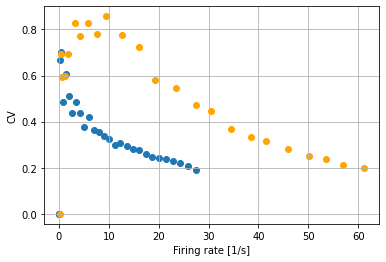

In [27]:
rate_reg, CV_reg = rate,CV

N = 40
t_sim = 25E3  # [ms]
CV = np.nan * np.ones(N)
rate = np.nan * np.ones(N)
for i, mu in enumerate(np.logspace(np.log10(150.), np.log10(700.), N)):
    spike_times = evaluate_neuron("iaf_psc_alpha_adapt_thresh_OU_nestml",
                                  stimulus_type="Ornstein-Uhlenbeck",
                                  mu=mu,
                                  sigma=100.,
                                  t_sim=t_sim,
                                  plot=False,
                                  neuron_parms={"Delta_Theta" : 5.})

    rate[i] = len(spike_times) / (t_sim / 1E3)

    ISI = np.diff(spike_times)
    if len(ISI) > 0:
        ISI_mean = np.mean(ISI)
        ISI_std = np.std(ISI)
        CV[i] = ISI_std / ISI_mean

fig, ax = plt.subplots()
ax.scatter(rate, CV)
ax.scatter(rate_reg, CV_reg, color="orange")
ax.set_xlabel("Firing rate [1/s]")
ax.set_ylabel("CV")
ax.grid()

Spike train autocorrelation
---------------------------

Autocorrelogram: histogram of time differences between (not necessarily adjacent) spikes.


In [28]:
def spike_train_autocorrelation(spike_times, half_wind=50., plot=True):
    """
    Parameters
    ----------
    half_wind : float
        Half the window size in milliseconds.
    """

    times = []
    for t1 in spike_times:
        for t2 in spike_times:
            times.append(t2 - t1)

    count, bin_edges = np.histogram(times, bins=41, range=(-half_wind, half_wind))
    count = np.array(count) / len(times)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.

    if plot:
        fig, ax = plt.subplots()
        #ax.bar(bin_centers, count, width=.8 * (bin_edges[1] - bin_edges[0]))
        ax.plot(bin_centers, count, marker="o")
        ax.set_xlabel("$\\Delta$t [ms]")
        ax.grid()

    return bin_edges, count

The spike autocorrelogram for a regularly spiking neuron should show peaks at the firing period, and multiples thereof:

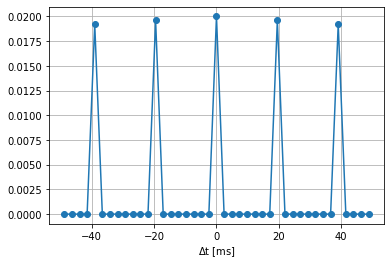

In [29]:
spike_times = np.arange(0., 1000., 20.) 
_ = spike_train_autocorrelation(spike_times)

The spike autocorrelogram for a Poisson process should only show a peak around $\Delta{}t$=0 for any rate:

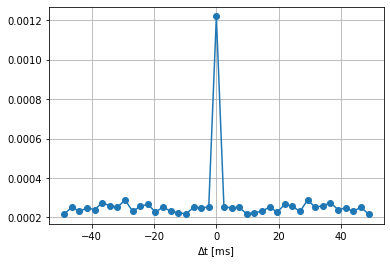

In [30]:
spike_times = np.cumsum(np.random.exponential(10., 1000))  # cumsum turns ISIs into sequential spike times
_ = spike_train_autocorrelation(spike_times)

**Task:** Use the ``spike_train_autocorrelation()`` function to determine if neurons with and without adaptation are Poissonian in their response, when driven with a noisy input.

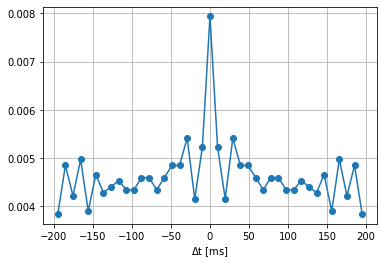

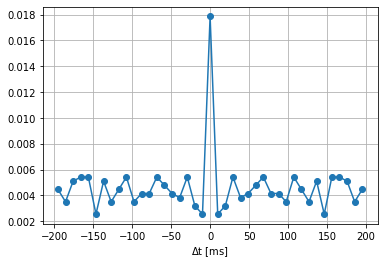

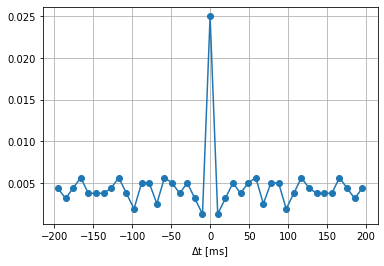

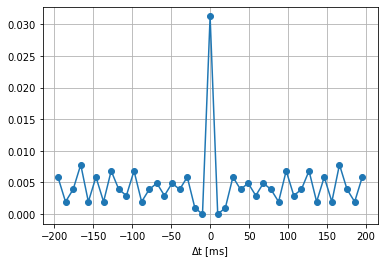

In [31]:
def autocorr(spike_times):
    ISI = np.diff(spike_times)
    num = 0.
    den = 0.
    for i in range(len(ISI) - 1):
        num += ISI[i] * ISI[i+1] - np.mean(ISI)**2
        den += ISI[i]**2 - np.mean(ISI)**2
        
    sum = num / den / (len(ISI) - 1)
    return sum

N = 4
c = np.nan * np.ones(N)
rate = np.nan * np.ones(N)
#for i, mu in enumerate(np.logspace(np.log10(50.), np.log10(400.), N)):
mu = 500.
for i, dth in enumerate(np.linspace(0., 10., N)):
    spike_times = evaluate_neuron("iaf_psc_alpha_adapt_thresh_OU_nestml",
                                      stimulus_type="Ornstein-Uhlenbeck",
                                      mu=mu,
                                      sigma=500.,
                                      t_sim=2000.,
                                      plot=False,
                                      neuron_parms={"Delta_Theta" : dth,
                                                    "tau_Theta" : 100.})
    _ = spike_train_autocorrelation(spike_times, half_wind=200.)
    isi = np.diff(spike_times)
    c[i] = np.std(isi) / np.mean(isi)#autocorr(spike_times)
    times = []
    for t1 in spike_times:
        for t2 in spike_times:
            times.append(t2 - t1)

    rate[i] = len(spike_times) / 10.


### More characterisation

**Meta task:** How would you improve this tutorial? Extend it and share by submitting a pull request on https://github.com/nest/nestml/!

For more inspiration, try to reproduce the following figures:

- Figure 5D from [2]
- Autocorrelation: figure 8D from [3]
- ISI correlation coefficient: figure 8B from [4]

Or try to see what the effect is of eliminating the membrane potential reset after spiking in the adaptive threshold model [2].

References
----------

[1] Victor J. Barranca, Han Huang, and Sida Li. The impact of spike-frequency adaptation on balanced network dynamics. Cogn Neurodyn. 2019 Feb; 13(1): 105–120. https://doi.org/10.1007/s11571-018-9504-2

[2] Rony Azouz and Charles M. Gray. Dynamic spike threshold reveals a mechanism for synaptic coincidence detection in cortical neurons in vivo. PNAS July 5, 2000 97 (14) 8110-8115; https://doi.org/10.1073/pnas.130200797

[3] Ryota Kobayashi & Katsunori Kitano. "Impact of slow K+ currents on spike generation can be described by an adaptive threshold model" Journal of Computational Neuroscience volume 40, pages 347–362 (2016) https://link.springer.com/article/10.1007/s10827-016-0601-0#Equ8

[4] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1995006/










